In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 1080,
        'scroll': True,
})

{'width': 1920, 'height': 1080, 'scroll': True}

# Week 04, ASTR 596: Fundamentals of Data Science


## MLE to Bayes, contd.

### Gautham Narayan 
##### <gsn@illinois.edu>



# <center> Review of HW 2 </center>

# Recap 


You should be able to:

* use MLE to estimate parameters of a model
    * analytically, in the case of nice likelihood functions
    * numerically (on a grid or using an optimizer)

# Recap

* recognize that the **likelihood function** is central to both Frequentist and Bayesian frameworks
    * but is *not* the same as the **posterior** 
    * in particular, the likelihood function is not the PDF for the parameters: 
    * probability of observing the data, given different values of the parameters $P(D|\theta)$
        * if you draw a 1-$\sigma$ contour around the MLE estimate and repeat the experiment over and over, 68% of the data should contain the true value - **Confidence Interval**
        * i.e. you have to imagine repeat experiments that haven't actually been done
    * in the frequentist view, the true parameters are fixed and *unknown*, but not *random*
    * and data are (random) realizations of random variables

# Recap

* In the Bayesian view, both parameters are data are random variables
    * data are random variables with realizations you've observed
    * parameters are random variables that you've not observed
* They are described by a joint distribution, $P(D,\theta) = P(D|\theta)\cdot P(\theta)$ 
    

# Recap

* what we want is the probability of the parameters, given the data we observed
    * what distribution of parameters can describe these observations $P(\theta|D)$
    * Bayes' rule relates $P(\theta|D)$ and $P(D|\theta)$
* the big difference between the two is the **prior**
    * the probability of the parameters *without* any data
    * **this is a subjective choice which we get to make!**
    * it is your degree of belief in the model
    * the posterior is your degree of belief in the model, updated by the data you observed

# Recap
* We want to pick our prior to be "weak" or "uninformative"
    * In the case of "big" enough data, the prior shouldn't matter
    * It is precisely when we do not have big enough data that we rely on the prior      
* MLE is a special case of maximum a posteriori inference with a uniform/flat prior

# Quick note, since some of you computed contours on HW2:

## Confidence intervals from $\chi^2$ distributions

* For example: in 1D, the 68.3% confidence region is bounded by the contour at $\chi^2_{\rm min} + \Delta \chi^2_{D}$ where $\Delta \chi^2_{D} = 1$ in 1D, and $\Delta \chi^2_{D} = 2.30$ in 2D. 

* In the 1D case, the boundary of the 68.3% confidence interval lies 1 standard deviation (or "1-sigma") from the mean, while the 95.4% CI lies 2-sigma from the mean.

> Remember, general, $\Delta \chi^2_{D}$ can be computed from the $\chi^2$ distribution quantile (or "percentage point") function, e.g.  `scipy.stats.chi2.ppf(0.683, D)`

* The $\chi^2$ function can be computed on a grid, and visualized as a contour plot: the contour at $\chi^2_{\rm min} + 2.30$ will enclose the 68% 2-D confidence region. **Not +1.0 in 2-D.**

In [2]:
import numpy as np
import scipy.stats as st


dimensions = 2
level = 0.683
dchisq = st.chi2.ppf(level, dimensions)

np.round(dchisq,2)

2.3

## Approximate uncertainties

* In general, the covariance matrix of a Gaussian approximation to the likelihood can be calculated by _taking second derivatives of the log likelihood at the peak_, and inverting the resulting *Hessian matrix/ negative Fisher Information Matrix*

* This gives a lower limit to the covariance of a set of estimators: 

## $\;\;\;\;\;V^{-1}_{ij} \geq -\frac{\partial^2 \log{L}}{\partial\theta_i\partial\theta_j} \biggr|_{\boldsymbol{\hat{\theta}}}$

> $V$ is what [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.minimize.html) returns in its `hess_inv` field if you pass it the negative log likelihood.

* We've been optimizing on grids so far for pedagogical reasons - you can visualize them easily

* In practice, don't actually write for loops over grids... 
    * if you justify a likelihood for your data that is a nice function, find a solution analytically
    * if you cannot, it's much more efficient to use scipy/iminuit/MCMC methods
    
    

# These are *confidence intervals*, **NOT** *credible regions**

Let's look at the difference using a version of the HW2 problems 2 and 3:

Let's assume we have some sources that are normally distributed with some mean $\mu = -19.5$ and standard deviation, $\sigma_{\text{int}} = 0.15$, both of which we want to estimate.

## $$ x_i \sim N(\mu, \sigma_{\text{int}}) $$


You have to *measure* the brightness of these sources and that process is noisy, so let's also assume that the measurements have some homoscedastic (i.e. equal) measurement error, say 0.1

## $$\sigma_i = 0.1$$

and 

## $$y_i \sim N(x_i, \sigma_i)$$

These $x_i$ are the true brightness of each source $i$ but we don't observe them directly - these are **latent** variables.

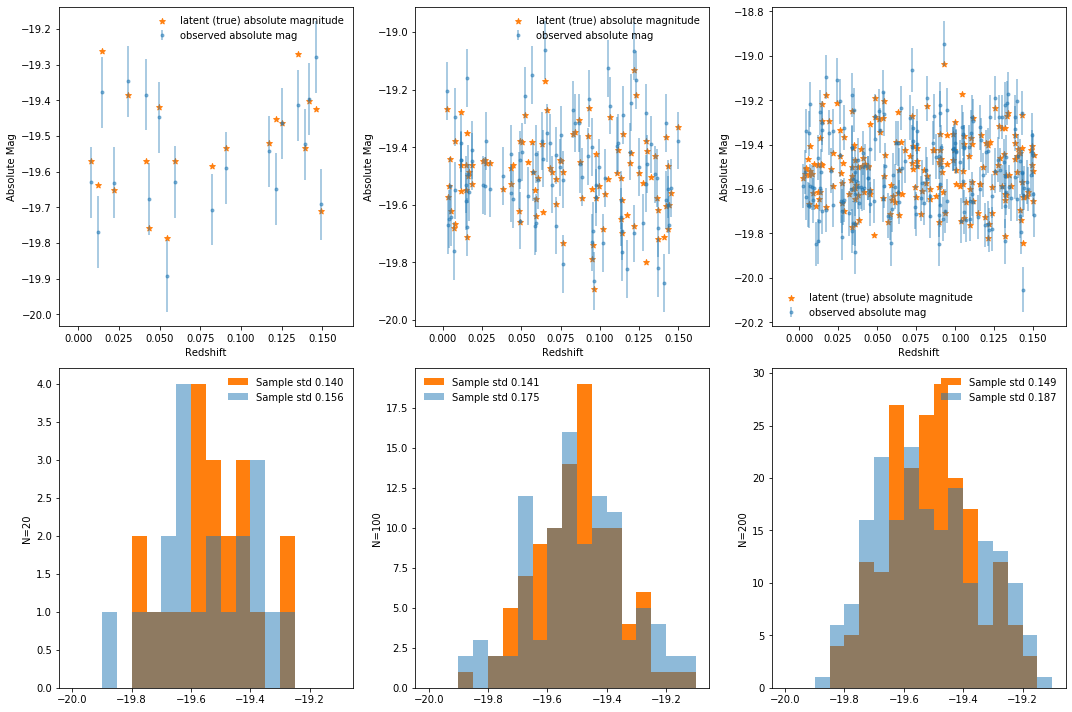

In [3]:
# RUN THIS

%matplotlib inline
import matplotlib.pyplot as plot
from scipy.optimize import minimize
from astropy.visualization import hist as ahist

np.random.seed(42)

#let's make three sample sizes
sample_size = [20, 100, 200]

fig = plt.figure(figsize=(15, 10))

# we'll fix the bins to make comparison easy
bins = np.arange(-20.0, -19.05, 0.05)

# and create ad dictionary to store the samples
samples={}

mu_true = -19.5
sig_int = 0.15

for s, size in enumerate(sample_size):

    ax1 = fig.add_subplot(2, 3, s+1)
    x = st.norm.rvs(loc=mu_true, scale=sig_int, size=size)
    
    error = np.repeat(0.1, size)
    
    # this also works in the case of heteroskedastic error
    #error =  st.uniform.rvs(loc=0.07, scale=0.2, size=size)

    y = x + st.norm.rvs(loc=0, scale=error, size=size)
    

    z = st.uniform.rvs(loc=0.001, scale=0.15, size=size )
        
    ax1.scatter(z, x, color='C1', marker='*', label='latent (true) absolute magnitude')
    ax1.errorbar(z, y, yerr=0.1, color='C0', marker='.', ls='None', alpha=0.5, label='observed absolute mag')
    ax1.set_xlabel('Redshift')
    ax1.set_ylabel('Absolute Mag')
    
    ax2 = fig.add_subplot(2, 3, s+4)
    
    # calculate the sample standard deviation
    sig_x = np.std(x)
    sig_y = np.std(y)
    
    # histogram the data
    ahist(x, color='C1', ax=ax2, bins=bins, label=f'Sample std {sig_x:.3f}')
    ahist(y, color='C0', alpha=0.5, ax=ax2, bins=bins, label=f'Sample std {sig_y:.3f}')
    ax2.set_ylabel(f'N={size:d}')
    ax1.legend(frameon=False)
    ax2.legend(frameon=False)
    
    samples[s] = (x, y, z, error)
fig.tight_layout()        

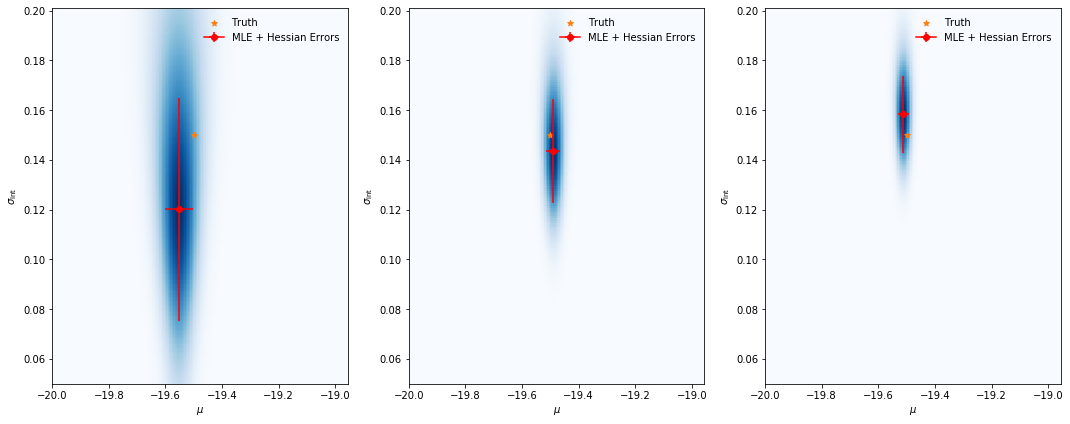

In [4]:
# RUN THIS

# we're going to define a grid - this should be familiar by now
mu_grid = np.arange(-20., -18.955, 0.005)
sig_grid = np.arange(0.05, 0.201, 0.001)
extent= (mu_grid.min(), mu_grid.max(), sig_grid.min(), sig_grid.max())

#starting guess for minimize since we want the Hessian
guess = np.array([-19.1, 0.2])

# and create a figure
fig = plt.figure(figsize=(15, 6))

# and save the results by sample size
results = {}

for s, size in enumerate(sample_size):
    x, y, z, error = samples[s]
    ax = fig.add_subplot(1, 3, s+1)
    
    likelihood_surface = np.zeros((mu_grid.shape[0], sig_grid.shape[0]))
    
    def negLogLike(theta):
        mu, sigma = theta
        if sigma <= 0.03 or sigma >= 0.3:
             return np.inf
            
        sig_total = np.sqrt(sigma**2. + error**2)
        like = st.norm.pdf(y, loc=mu, scale=sig_total)
        return  -0.5*np.sum(np.log(like))
    
    for i, trial_mu in enumerate(mu_grid):
        for j, trial_sig in enumerate(sig_grid):
            likelihood_surface[i, j] = np.exp(-(negLogLike((trial_mu, trial_sig))))
            
    ax.imshow(likelihood_surface.T, cmap='Blues', extent=extent, aspect='auto', origin='lower')
    
    res = minimize(negLogLike, guess)
    mle = res.x
    err_mu = res.hess_inv[0, 0]**0.5
    err_sig = res.hess_inv[1, 1]**0.5
    ax.errorbar([mle[0],], [mle[1],], xerr =err_mu, yerr=err_sig, color='red', marker='o',\
                label='MLE + Hessian Errors')
    ax.scatter([mu_true,], [sig_int,], color='C1', marker='*', label='Truth')
    ax.legend(frameon=False)
    ax.set_xlabel(r'$\mu$')
    ax.set_ylabel(r'$\sigma_{\mathrm{int}}$')
    
    results[s] = (mle, (err_mu, err_sig))
fig.tight_layout()

## Notice how in this case with a non-linear function where there is no analytical solution to the MLE, numerical optimization still works fine, and you get convergence as the sample size gets larger


## Notice also that the confidence intervals don't seem to have much connection to the truth, but rather describe the likelihood surface... i.e. $P(D|\theta)$

## If you could repeat this experiment k times for different D, 68% of the the results should be in your CI.




There's plenty of Non-linear functions. For our Cepheids we wrote:

## $$ m = a\log P + b $$

and we know we can write (from week 1)

## $$ m - M  = 5\log (d_L/10 \, \text{pc}) $$

Some rearranging then: 

## $$ d_L = 10^{\left(a\log P + b -  M + 5 \right)/5} $$

and Einstein's equations give us.. 

## $$ d_L(z) = (1+z)\cdot (c/H_0) \int_{0}^{z} dz^\prime \; \left( \Omega_{\text{M}} (1+z^\prime)^3 + \Omega_{\text{DE}} (1+z^\prime)^{3(1+w)} \right)^{-1/2}  $$

which in the nearby Universe reduces to distance scaling linearly with redshift and therefore recession velocity.

 # <center> We already know the prior can alter the inference we make, but just to drive home the point... </center>


![Bayesians vs Frequentists](bayes_vs_frequentist.png)


## Things to remember

* The most important thing is to _know what you are doing_, and to _communicate that clearly to others_: both approaches involve assumptions which must be recorded and tested

* The Bayesian approach provides a logical framework for combining datasets and additional information, and provides answers in terms of the probability distribution for the model parameters

* The Frequentist approach provides a way of studying the model independent of additional information beyond the dataset in hand, and provides answers in terms of the probability of getting the data

## Endnote

* The astronomy literature contains a mixture of frequentist and Bayesian analysis, sometimes within the same paper

* Frequentist estimators often make good _summary statistics_ with well understood sampling distributions: astronomical catalogs are full of them

* In most of this course we follow the Bayesian approach: Bayes' Theorem gives you a framework for deriving the solution to _any_ inference problem you encounter.  Having said that, we'll keep our eyes open.

## In class exercise/summary: Computing the Bayesian Posterior PDF

We saw the Riess et al, 2011 data on Cepehids last week.

Here's how the figures for the Bayesian inference were made - starting with the functions for the log likelihood, the log prior, and the unnormalized log posterior, evaluated on a 2D $(a,b)$ parameter grid given the R11 data.

This is a single worked example of covering everything in our recap.

In [5]:
exec(open('cepheids.py').read())
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)

data = Cepheids('../data/03/R11ceph.dat')

def log_likelihood(logP, mobs, sigma, a, b):
    return -0.5*np.sum(2*np.pi*sigma**2) - \
            0.5*np.sum((mobs - a*logP - b)**2/(sigma**2))

def log_prior(a, b):

    amin,amax = -10.0,10.0
    bmin,bmax = 10.0,30.0

    if (b > bmin)*(b < bmax):
        value = 0.0
# Interesting alterniative: Cauchy distribution for b, equivalent to uniform
# in angle of orientation of line:
#        value = np.log(1.0/(bmax-bmin)) - \
#                np.log(np.pi) - np.log(1 + a**2)
    else:
        value = -np.inf
    
    if (a > amin)*(a < amax):
        value += 0.0
    else:
        value += -np.inf
        
    return value

def log_posterior(logP, mobs, sigma, a, b):
    return log_likelihood(logP,mobs,sigma,a,b) + log_prior(a,b)

## Evaluating the posterior PDF

Now, let's set up a suitable parameter grid, evaluate the unnormalized log posterior on it, and then renormalize it numerically.

In [6]:
# Limits of parameter grids, focused on the high likelihood region:
amin, amax = -3.4, -2.4
bmin, bmax = 25.7, 26.8
limits = (amin, amax, bmin, bmax)

def evaluate_posterior_on_a_grid(limits, NGC_ID=4258, npix=100):
    
    # Make grids:
    amin, amax, bmin, bmax = limits
    agrid, bgrid, logprob = np.linspace(amin,amax,npix), np.linspace(bmin,bmax,npix), np.zeros([npix,npix])

    # Select a Cepheid dataset:
    data.select(NGC_ID)

    # Loop over parameters, computing unnormlized log posterior PDF:
    for i,a in enumerate(agrid):
        for j,b in enumerate(bgrid):
            logprob[j,i] = log_posterior(data.logP, data.mobs, data.sigma, a, b)

    # Exponentiate and normalize to get posterior density:
    prob = np.exp(logprob - np.max(logprob))
    prob /= np.sum(prob)
    
    return prob, agrid, bgrid

In [7]:
%%time
prob, a, b = evaluate_posterior_on_a_grid(limits, NGC_ID=4258, npix=100)

CPU times: user 244 ms, sys: 2.21 ms, total: 246 ms
Wall time: 252 ms


## Visualizing the 2D PDF

* Typically we want to be able to see the centroid, size and shape of the posterior PDF

* In particular we want to see the _credible regions_ that enclose 68% and 95% of the posterior probability. These are best plotted as contours

* Given our assumption that the model is true, the probability that the true values of the model parameters lie within the 95% credible region given the data is 0.95

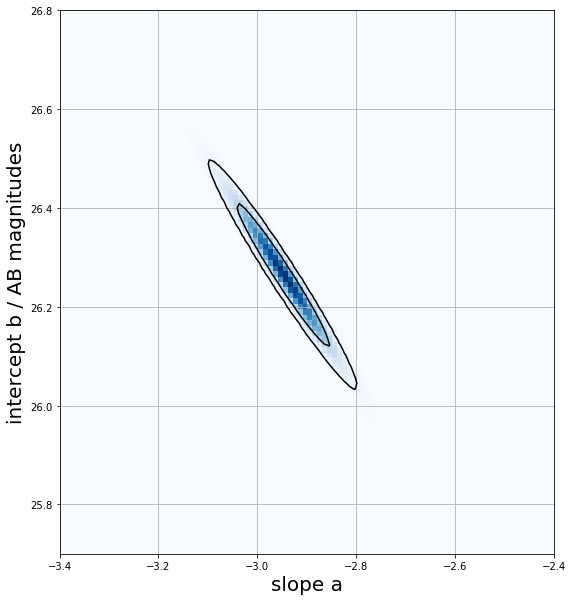

In [8]:
sorted = np.sort(prob.flatten())
C = sorted.cumsum()

# Find the pixel values that lie at the levels that contain 68% and 95% of the probability:
lvl68 = np.min(sorted[C > (1.0 - 0.68)])
lvl95 = np.min(sorted[C > (1.0 - 0.95)])

plt.figure(figsize=(10,10))
plt.imshow(prob, origin='lower', cmap='Blues', interpolation='none', extent=limits)
plt.contour(prob,[lvl95,lvl68],colors='black',extent=limits)
plt.grid()
plt.xlabel('slope a', fontsize=20)
plt.ylabel('intercept b / AB magnitudes', fontsize=20);

# plt.savefig("cepheids_2d-posterior.png");

## Summarizing our inferences

Let's compute the 1D marginalized posterior PDFs for $a$ and for $b$, and report the median and "68% credible interval" (defined as the region of 1D parameter space enclosing 68% of the posterior probability).

a =  $ -2.95^{+0.06}_{-0.06} $
b =  $ 26.27^{+0.09}_{-0.1} $


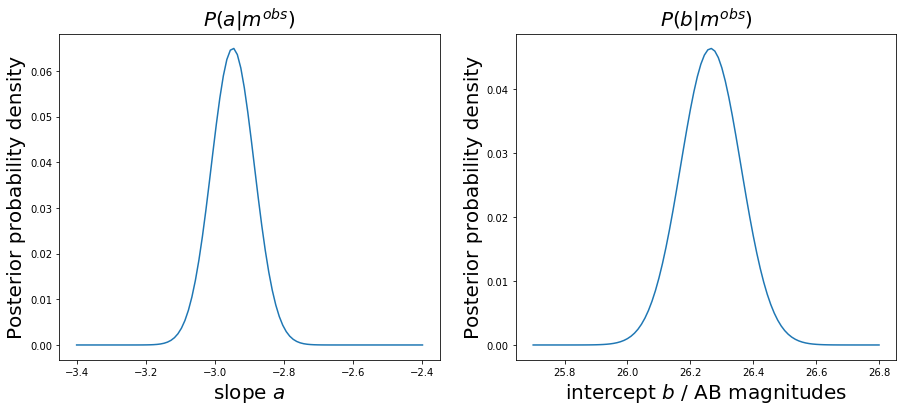

In [9]:
prob_a_given_data = np.sum(prob, axis=0) # Approximate the integral as a sum
prob_b_given_data = np.sum(prob, axis=1) # Approximate the integral as a sum

# Check that we do have a 1D PDF:
# print(prob_a_given_data.shape, np.sum(prob_a_given_data))

plot_1d_marginalized_pdfs(a, b, prob_a_given_data, prob_b_given_data)

# plt.savefig("cepheids_1d-posteriors.png")

print("a = ",compress_1D_pdf(a, prob_a_given_data, ci=68, dp=2))
print("b = ",compress_1D_pdf(b, prob_b_given_data, ci=68, dp=2)) 

## Post-inference model checking


Are these inferred parameters sensible? 

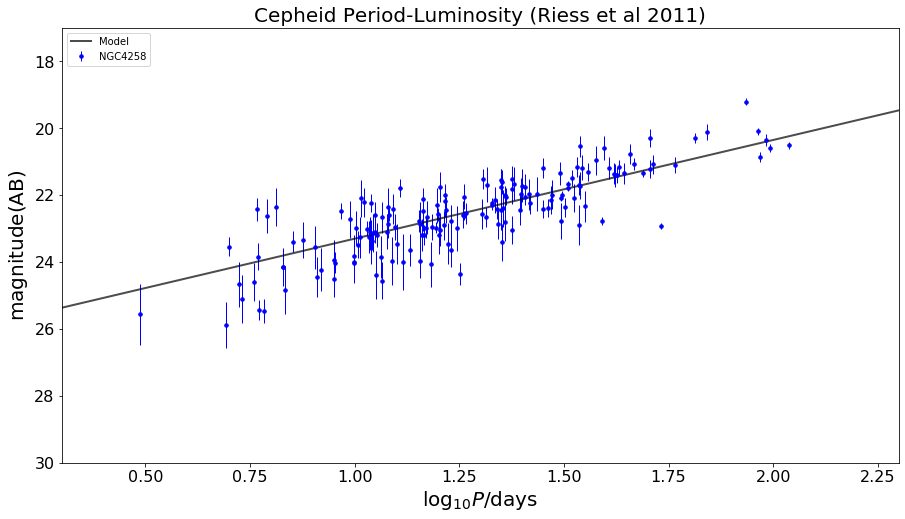

In [10]:
data.plot(4258)

data.overlay_straight_line_with(a=-2.95, b=26.25, label='Model')

data.add_legend()

# plt.savefig("cepheids_posterior-median-check.png")

## Appendix: Finding the Maximum likelihood parameters

Here's the code to find the maximum likelihood parameters in the Cepheid problem.

In [11]:
exec(open('cepheids.py').read())
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)

data = Cepheids('../data/03/R11ceph.dat')

In [12]:
data.select(4258)
M, v = data.sufficient_statistics()
a, b = np.linalg.solve(M, v)
print('$ \hat{a} = %.2f $' % np.round(a, 2))
print('$ \hat{b} = %.2f $' % np.round(b, 2))

$ \hat{a} = -2.95 $
$ \hat{b} = 26.26 $


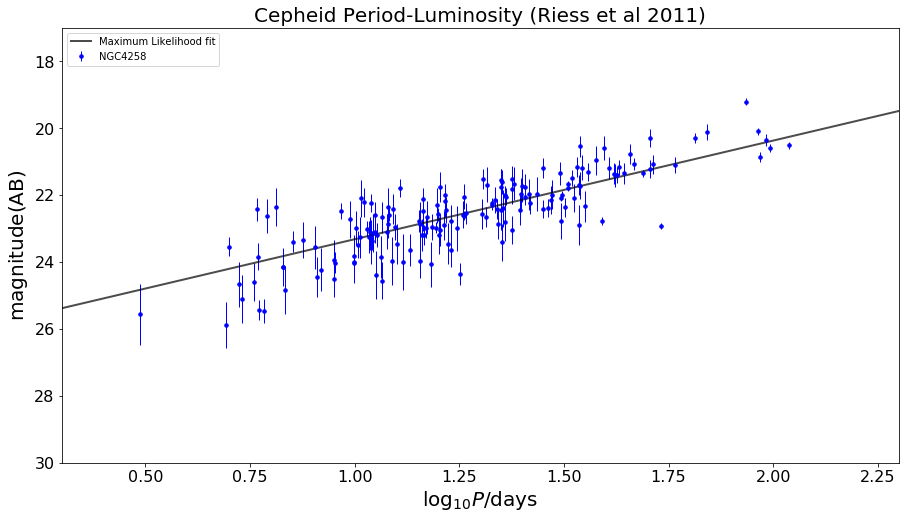

In [13]:
data.plot(4258)

data.overlay_straight_line_with(a=a, b=b, label='Maximum Likelihood fit')

data.add_legend()

## The covariance of MLEs

Here's code to compute the inverse Hessian of the log likelihood, and hence a lower limit on the covariance of the ML estimators. 

The diagonal elements of the covariance matrix give an approximate symmetrical error bar.

In [14]:
# Generalized maximum likelihood approach:

import scipy.optimize

pars = np.array([0.0, 20])
result = scipy.optimize.minimize(data.negative_log_likelihood, pars, method='BFGS', tol=0.001)

print(result)

      fun: 544.3090872704154
 hess_inv: array([[ 0.00384455, -0.0057908 ],
       [-0.0057908 ,  0.00913226]])
      jac: array([-5.34057617e-05,  7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([-2.94832756, 26.26490196])


In [15]:
C = result.hess_inv
np.sqrt(C[0,0]), np.sqrt(C[1,1])

(0.06200447408026502, 0.09556286237475098)

## In class exercise: Was the choice of a uniform prior actually uninformative?

* Draw a 1000 random values for a slope from a uniform distribution U(-10, 10)
* Plot the line y = ax 

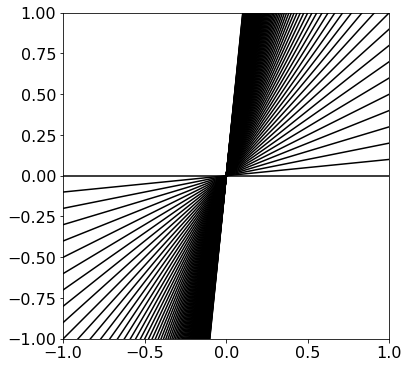

In [21]:
# YOUR CODE HERE
a = np.arange(0., 10, 0.1)
x = np.array([-1, 1])
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

for m in a:
    ax.plot(x, m*x, ls='-', color='k')
    

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')    



## How to pick a prior 

### Bayesian priors

Priors can be **informative** or **uninformative**.  As it sounds, informative priors are based on existing information (including previously obtained data, but not the data considered right now) that might be available.  Uniformative priors can be thought of as "default" priors, i.e., what your prior is when you never used
any data, e.g, a "flat" prior like $p(\theta|M,I) \propto {\rm C}$.

Detailed discussion can be found in Section 5.2 in the textbook. 

There are three main principles used to choose a prior: 


#### 1. The Principle of Indifference

Essentially this means adopting a uniform prior, though you have to be a bit careful.  Saying that an asteroid is equally likely to hit anywhere on the Earth is not the same as saying that all latitudes of impact are equally likely.  

Assuming $1/6$ for a six-side die, or 1/2 for heads and tails of a fair coin, would be an example of indifference.

#### 2. The Principle of Invariance (or Consistency)

This applies to location and scale invariance.  

**Location invariance** suggests a uniform prior, within the accepted bounds: $p(\theta|I) \propto 1/(\theta_{max}-\theta_{min})$ for $\theta_{min} \le \theta \le \theta_{max}$. 

BE CAREFUL - the probability of an asteroid hitting anywhere on Earth might be equal, but that does not mean it is uniform as a function of latitude! http://articles.adsabs.harvard.edu//full/1964Metic...2..271H/0000274.000.html

**Scale invariance** gives us priors that look like $p(\theta|I) \propto 1/\theta$, which implies a uniform
prior for ln($\theta$). 

#### 3. The Principle of Maximum Entropy

We will not discuss it here - for more details, see Section 5.2.2 in the textbook.
 
It is often true that Bayesian analysis and traditional MLE are essentially equivalent.  
However, in some cases, considering the priors can have significant consequences, as
we will see later. 

We will skip examples of very steep priors and their consequences called in astronomy
literature **Eddington-Malmquist** and **Lutz-Kelker** biases (see Chapter 5 in the textbook
if you are interested). 

## Statistical Modeling "Wisdom"

* Build a model for your data (ideally draw a PGM - we'll see more of these)

* Have an objective function (likelihood or posterior) that you optimize (or sample) to fit the the data

    * The objective function evaluates the fit of your one dataset under different parameter values/models
 
* Derive your objective function from modeling assumptions (physical or statistical)

* **Write down your assumptions!!!** (you'll need these when things go wrong)

## Statistical Modeling "Wisdom"

Four Questions for a Bayesian:

* What is the model?

* What is the likelihood? Derive $L(\theta)$ from your sampling distribution $P(D|\theta)$

* What are your priors $P(\theta)$?

* How do you optimize/sample this objective function to model the data?

In [17]:
# bootstrap
## priors to deal with selection effects - truncated data
## conjugate priors